In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from tqdm.notebook import tqdm, trange
from scipy.stats import norm
import matplotlib.pyplot as plt
from src.models import IsotropicGaussian
from src.core import check_intersections

import warnings
warnings.filterwarnings('ignore')

In [2]:
online_data_paths = [
    '../../data/2afc-pilot/data/63026a8fd8429b224cd2a134_MindSweeper2AFC_2024-08-15_21h03.35.273.csv',
    '../../data/2afc-pilot/data/65845dda978052080941c93a_MindSweeper2AFC_2024-08-15_17h54.17.152.csv',
    '../../data/2afc-pilot/data/6632d6381120b6cbed905bad_MindSweeper2AFC_2024-08-15_13h54.33.200.csv'
]

online_dfs = []
for i,path in enumerate(online_data_paths):
    # read in data data
    #data = pd.read_csv('../../data/H_imagery_2024-08-01_14h30.54.266.csv')
    data = pd.read_csv(path)
    data = data.loc[pd.notnull(data.target_file)]
    #print(len(data))

    correct = data.correct_resp
    resp = data['key_resp.keys'].values 
    if i == 2:
        new_resp = ['right' if r=='left' else 'left' for r in resp]
        data['key_resp.keys'] = new_resp
        resp = new_resp

    # mark the responses that were correct
    data['acc'] = np.array((resp==correct), dtype=int)
    online_dfs.append(data)
    
    
local_data_paths = [
    '../../data/KB_imagery_2024-08-02_12h02.03.323.csv',
    '../../data/H_imagery_2024-08-01_14h30.54.266.csv'
]

local_dfs = []
for path in local_data_paths:
    # read in data data
    #data = pd.read_csv('../../data/H_imagery_2024-08-01_14h30.54.266.csv')
    data = pd.read_csv(path)
    data = data.loc[pd.notnull(data.target_file)]
    #print(len(data))

    correct = data.correct_resp
    resp = data['key_resp.keys'].values

    # mark the responses that were correct
    data['acc'] = np.array((resp==correct), dtype=int)
    local_dfs.append(data)

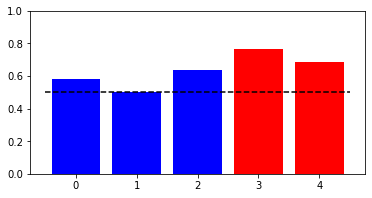

In [3]:
online_acc = [df.acc.mean() for df in online_dfs] 
local_acc = [df.acc.mean() for df in local_dfs] 


fig, ax = plt.subplots(figsize=(6, 3))

ax.bar(np.arange(len(online_acc) + len(local_acc)), online_acc + local_acc, color=['b', 'b', 'b', 'r', 'r'])

ax.plot([-.5, 4.5], [.5, .5], linestyle='--', color='black')

ax.set_ylim(0, 1)

plt.show()

In [4]:
for df in online_dfs:
    tids = df.target_id.values
    new_tc = [(tid // 4) + 2 for tid in tids]
    df['target_complexity'] = new_tc
        

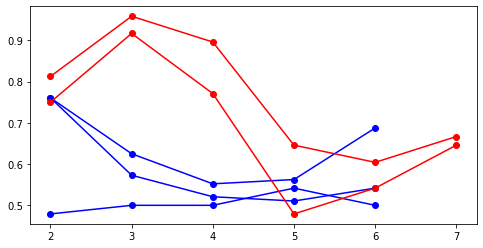

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))


for i,df in enumerate(online_dfs):
    tcs = list(set(df.target_complexity.values))
    acc = []
    for tc in tcs:
        d = df[df.target_complexity == tc]
        acc.append(d.acc.mean())
    ax.plot(tcs, acc, color='blue')
    ax.scatter(tcs, acc, color='blue')

for df in local_dfs:
    tcs = list(set(df.target_complexity.values))
    acc = []
    for tc in tcs:
        d = df[df.target_complexity == tc]
        acc.append(d.acc.mean())
    ax.plot(tcs, acc, color='red')
    ax.scatter(tcs, acc, color='red')



In [6]:
from src.probes import generate_custom_probe_set_ext

def load_curves(output_path, n_curves):
    curves_path = output_path + '/curves'
    knots_path = output_path + '/knots'
    curves = [np.loadtxt(curves_path + f'/curve_{i}.txt') for i in range(n_curves)]
    knots = [np.loadtxt(knots_path + f'/knots_{i}.txt') for i in range(n_curves)]
    knots = [np.reshape(k, (len(k) // 2, 2)) for k in knots]
    return curves, knots
    
def split_by_complexity(X, n_targets_per_complexity):
    return np.array([X[i:i+n_targets_per_complexity] for i in range(0, len(X), n_targets_per_complexity)])

def compute_SNR(X):
    S = X.mean(axis=2).var(axis=1)
    N = X.var(axis=2).mean(axis=1)
    SNR = S/N
    return SNR.mean()

def compute_d_prime(X, X_hat):
    X = X.flatten()
    X_hat = X_hat.flatten()
    
    n_signal = len(X[X==1])
    n_noise =  len(X[X==0])
    n_hits =  (X_hat[X==1]).sum()
    n_fa =    (X_hat[X==0]).sum()
    
    H = n_hits / n_signal
    F = n_fa / n_noise
    d_prime = norm.ppf(H) - norm.ppf(F)
    return d_prime


In [7]:
#targets, knots = load_curves('../../stimuli/PILOT_07', 20)
targets, knots = load_curves('../../stimuli/UNTITLED4', 12)
probes = generate_custom_probe_set_ext(2, ext=.2, plot=False)

In [62]:
def run_simulation(targets, knots, probes, n_repeats, tau=7, capacity=2):
    n_targets, n_probes = len(targets), len(probes)
    X = np.ones((n_targets, n_probes, n_repeats)) *-1
    C = np.ones((n_targets, n_probes, n_repeats)) *-1
    R = np.ones((n_targets, n_probes, n_repeats)) *-1
    X_hat = np.ones((n_targets, n_probes, n_repeats)) *-1
    R_hat = np.ones((n_targets, n_probes, n_repeats)) *-1

    for i,(t,k) in enumerate(zip(targets, knots)):
        model = IsotropicGaussian(k, capacity, tau)
        sample = model.sample_curves(n_probes*n_repeats)
        for j,p in enumerate(probes):
            _,n = check_intersections(t, p)
            if n == 0:
                c = .5
            else:
                c = n+.5 if ((i+j)%2 == 0) else n-.5
            r = 1 if n > c else 0
            for k in range(n_repeats):
                X[i, j, k] = n
                C[i, j, k] = c
                R[i, j, k] = r
                _,n_hat = check_intersections(sample[(j*n_repeats) + k], p)
                X_hat[i, j, k] = n_hat
                R_hat[i, j, k] = 1 if n_hat > c else 0
    
    return X, X_hat, R, R_hat

def run_n_simulations(target_curves, knots, probes, n_sims, n_samples, nc, npc, capacity, tau):
    X = np.zeros((n_sims, 3, nc))
    for i in trange(n_sims):
        _,_,R_vis_sim, R_img_sim = run_simulation(target_curves, 
                                                  knots, 
                                                  probes, 
                                                  n_samples, 
                                                  capacity=capacity, 
                                                  tau=tau)
        A_sim = (R_img_sim == R_vis_sim).astype(int)
        E_sim = R_img_sim - R_vis_sim
        avg_error_sim = [e.mean() for e in split_by_complexity(E_sim, npc)]
        avg_acc_sim = [a.mean() for a in split_by_complexity(A_sim, npc)]
        avg_var_sim = [x.var(axis=2).mean() for x in split_by_complexity(R_img_sim, npc)]
        #avg_snr_sim = [compute_SNR(x) for x in split_by_complexity(R_img_sim, npc)]

        R_sim = list(zip(split_by_complexity(R_vis_sim, npc), split_by_complexity(R_img_sim, npc)))
        d_prime_sim = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R_sim]

        for j in range(nc):
            #X[i][0][j] = avg_error_sim[j]
            X[i][0][j] = avg_acc_sim[j]
            X[i][1][j] = avg_var_sim[j]
            X[i][2
                ][j] = d_prime_sim[j]
            
    return X
    
    
def compute_Y(dfs, npc, nc):
    Y = np.zeros((len(dfs), 4, nc))

    for sid, data in enumerate(dfs):
        n_targets = len(list(set(data.target_id.values)))
        n_probes = len(list(set(data.probe_id.values)))
        n_repeats = len(data[(data.target_id==0) & (data.probe_id==0)])

        # compute the accuracy and error tensors
        R_img = np.ones((n_targets, n_probes, n_repeats)) * -1
        R_vis = np.ones((n_targets, n_probes, n_repeats)) * -1
        X_comp = np.ones((n_targets, n_probes, n_repeats)) * -1
        X_vis = np.ones((n_targets, n_probes, n_repeats)) * -1

        for tid in range(n_targets):
            for pid in range(n_probes):
                d = data[(data.target_id == tid) & (data.probe_id == pid)]
                resps = d['key_resp.keys'].values
                cor = d['correct_resp'].values
                try:
                    comp = d['comparator'].values
                except:
                    comp = d['comparison'].values 
                visn = d['n_isecs'].values
                for i, (r, c) in enumerate(zip(resps, cor)):
                    R_img[tid, pid, i] = 1 if r == 'right' else 0
                    R_vis[tid, pid, i] = 1 if c == 'right' else 0
                    X_comp[tid, pid, i] = comp[i]
                    X_vis[tid, pid, i] = visn[i]

        A = (R_img == R_vis).astype(int)
        E = R_img - R_vis

        avg_error = [e.mean() for e in split_by_complexity(E, npc)]
        avg_acc = [a.mean() for a in split_by_complexity(A, npc)]
        avg_var = [x.var(axis=2).mean() for x in split_by_complexity(R_img, npc)]
        avg_snr = [compute_SNR(x) for x in split_by_complexity(R_img, npc)]
        R = list(zip(split_by_complexity(R_vis, npc), split_by_complexity(R_img, npc)))
        d_prime = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R]

        for j in range(len(avg_error)):
            #Y[sid, 0, j] = avg_error[j]
            Y[sid, 0, j] = avg_acc[j]
            Y[sid, 1, j] = avg_var[j]
            Y[sid, 2, j] = d_prime[j]
            
    return Y
    
    
def make_plots(X, Y, fig, ax):
    fs = 16
    #fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6), sharex=True)
    x_range = np.arange(2, 13, 2)
    colors = ['slategrey', 'red']
    for x, color in zip([X, Y[:2,:,:]], colors):
        for i in range(len(x)):
            labels = ['accuracy', 'variance', 'd-prime']
            for j,label in enumerate(labels):
                if color == 'slategrey':
                    ax[j].plot(x_range, x[i][j], c='black', alpha=.05)
                if color=='slategrey':
                    #ax[r][c].plot(x_range, np.nanmean(x, axis=0)[0], c='black')
                    ax[j].plot(x_range, x.mean(axis=0)[j], c='black')
                else:
                    ax[j].plot(x_range, x[i][j], c=color, alpha=.1)
                    ax[j].plot(x_range, x.mean(axis=0)[j], c=color)


                ax[j].set_ylabel(label, fontsize=fs)

            for j, label in enumerate(labels):   
                xlower, xupper = [],[]
                ylower, yupper = [],[]

                for i in range(len(x_range)):
                    xlow, xhigh = st.t.interval(alpha=.99, df=n_sims-1, loc=x[:,j,i].mean(), scale=st.sem(x[:,j,i]))
                    xlower.append(xlow)
                    xupper.append(xhigh)
                if color == 'slategrey':
                    ax[j].fill_between(x_range, xlower, y2=xupper, color=color, alpha=.02)


            for i in range(len(ax)):
                    ax[i].set_xticks(x_range)
                    ax[i].spines['top'].set_visible(False)
                    ax[i].spines['right'].set_visible(False)
                    #ax[i][j].set_xlabel('complexity')


    ax[0].set_xlim(1.5, 12.5)
    ax[0].set_xticks(x_range)
    ax[2].set_xlabel('stimulus complexity', fontsize=fs)
    #ax[0].legend()
    #ax[-1].set_xlabel('complexity')
    fig.tight_layout()
    plt.subplots_adjust(wspace=.2, hspace=.2)
    plt.show()


In [16]:
np.arange(2, 13, 2)

array([ 2,  4,  6,  8, 10, 12])

In [17]:
X.shape

(10, 5, 6)

  0%|          | 0/10 [00:00<?, ?it/s]

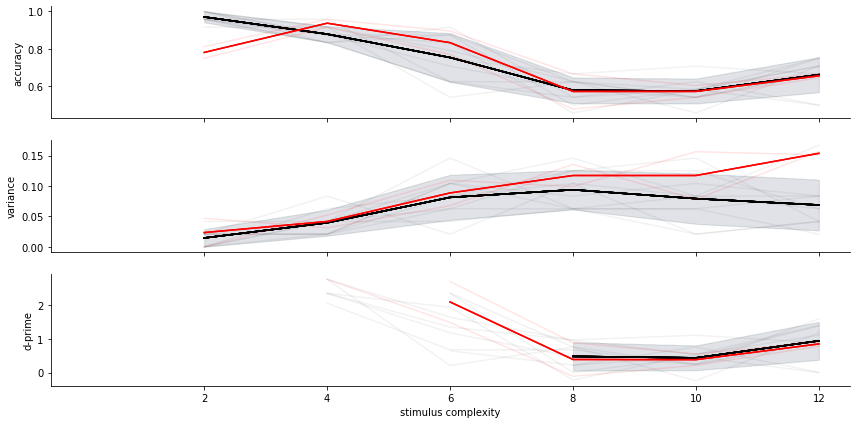

In [18]:
C,tau = 10, 7
nc,npc = 6, 2
n_sims,n_samples = 10, 2
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(local_dfs, npc, nc)

fig, ax = plt.subplots(nrows=3, figsize=(12,6), sharex=True)
make_plots(X,Y, fig, ax)
plt.show()

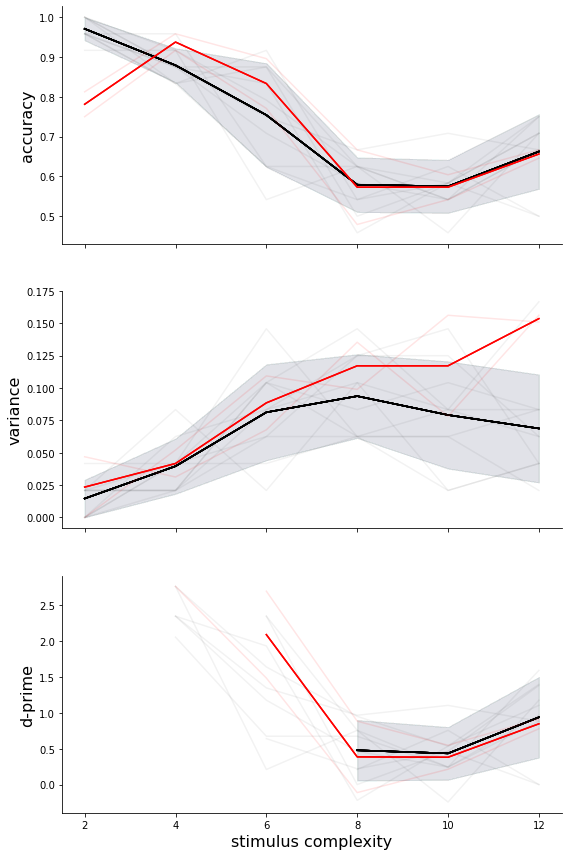

In [64]:

fig, ax = plt.subplots(nrows=3, figsize=(8,12), sharex=True)
make_plots(X,Y, fig, ax)
#ax[0].legend()
fig.savefig('res.png', dpi=400)
plt.show()

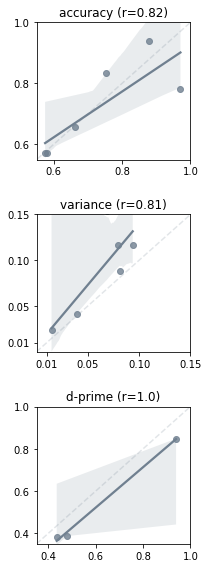

In [71]:
import seaborn as sns

from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(3, 8), nrows=3)

for i,label in enumerate(['accuracy', 'variance', 'd-prime']):
    x = X.mean(axis=0)[i]
    y = Y.mean(axis=0)[i]
    if i == 2:
        mask1 = y!=np.inf
        mask2 = x!=np.inf
        mask = mask1 & mask2
        x = x[mask]
        y = y[mask]
    a = ax[i]
    try:
        r = pearsonr(x, y)[0]
        a.set_title(f'{label} (r={round(r, 2)})')
    except:
        pass
    
    sns.regplot(x, y, ax=a, color='slategrey')
    
ax[0].set_xlim((.55, 1))
ax[0].set_ylim((.55, 1))
ax[0].set_xticks([.6, .8, 1])
ax[0].set_yticks([.6, .8, 1])
ax[0].plot([.5, 1], [.5, 1], linestyle='--', color='slategrey', alpha=.2)
ax[1].set_xlim((0, .15))
ax[1].set_ylim((0, .15))
ax[1].plot([0, .2], [0, .2], linestyle='--', color='slategrey', alpha=.2)
ax[1].set_xticks([.01, .05, .1, .15])
ax[1].set_yticks([.01, .05, .1, .15])
ax[2].set_xlim((.35, 1))
ax[2].set_ylim((.35, 1))
ax[2].plot([.35, 1], [.35, 1], linestyle='--', color='slategrey', alpha=.2)
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)
fig.savefig('results3.png', dpi=400)
plt.show()

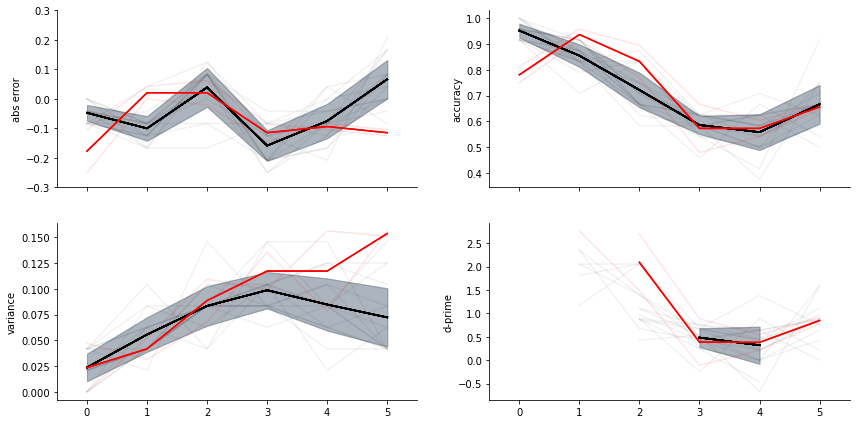

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6), sharex=True)
make_plots(X,Y, fig, ax)

fig.savefig('results0.png', dpi=400)

In [32]:
a = np.array([True, False, False])
b = np.array([False, False, True])
a | b

array([ True, False,  True])

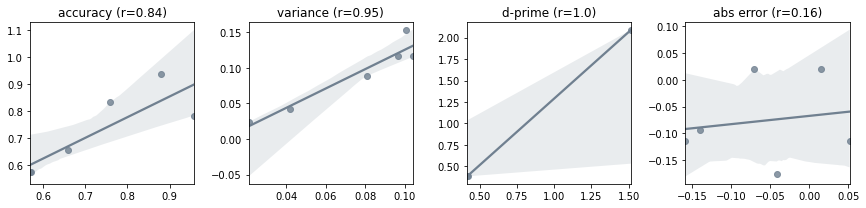

In [34]:
import seaborn as sns

from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(12, 3), ncols=4)

for i,label in enumerate(['abs error', 'accuracy', 'variance', 'd-prime']):
    x = X.mean(axis=0)[i]
    y = Y.mean(axis=0)[i]
    if i == 3:
        mask1 = y!=np.inf
        mask2 = x!=np.inf
        mask = mask1 & mask2
        x = x[mask]
        y = y[mask]
    if i == 0:
        a = ax[3]
    else:
        a = ax[i-1]
    try:
        r = pearsonr(x, y)[0]
        a.set_title(f'{label} (r={round(r, 2)})')
    except:
        pass
    
    sns.regplot(x, y, ax=a, color='slategrey')
    
plt.tight_layout()
fig.savefig('results2.png', dpi=400)
plt.show()

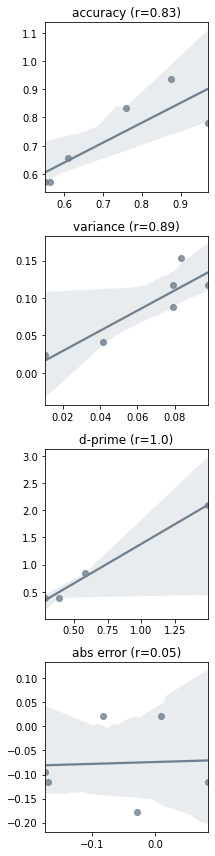

In [65]:
import seaborn as sns

from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(3, 12), nrows=4)

for i,label in enumerate(['abs error', 'accuracy', 'variance', 'd-prime']):
    x = X.mean(axis=0)[i]
    y = Y.mean(axis=0)[i]
    if i == 3:
        mask = y!=np.inf
        x = x[mask]
        y = y[mask]
    if i == 0:
        a = ax[3]
    else:
        a = ax[i-1]
    try:
        r = pearsonr(x, y)[0]
        #ax[i].set_title(str(round(r, 2)))
        a.set_title(f'{label} (r={round(r, 2)})')
    except:
        pass
    
    sns.regplot(x, y, ax=a, color='slategrey')
    
plt.tight_layout()
fig.savefig('results2.png', dpi=400)
plt.show()

In [50]:
Y.mean(axis=0)[3] != np.inf

array([False, False,  True,  True,  True,  True])

In [36]:
local_dfs[0]

,target_file,probe_file,n_isecs,target_id,probe_id,target_complexity,probe_complexity,isecs_image,comparison,correct_resp,...,ready.stopped,goodbyeText.started,participant,session,date,expName,psychopyVersion,frameRate,Unnamed: 72,acc
3,./resources/curve_2_black.png,./resources/curve_1_pink.png,1.0,2.0,1.0,3.0,2.0,./resources/isecs_2_1.png,0.5,right,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1
4,./resources/curve_2_black.png,./resources/curve_3_pink.png,2.0,2.0,3.0,3.0,2.0,./resources/isecs_2_3.png,1.5,right,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1
5,./resources/curve_11_black.png,./resources/curve_2_pink.png,3.0,11.0,2.0,7.0,2.0,./resources/isecs_11_2.png,2.5,right,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,0
6,./resources/curve_11_black.png,./resources/curve_1_pink.png,6.0,11.0,1.0,7.0,2.0,./resources/isecs_11_1.png,6.5,left,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1
7,./resources/curve_10_black.png,./resources/curve_4_pink.png,5.0,10.0,4.0,7.0,2.0,./resources/isecs_10_4.png,5.5,left,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,./resources/curve_11_black.png,./resources/curve_3_pink.png,4.0,11.0,3.0,7.0,2.0,./resources/isecs_11_3.png,4.5,left,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,0
287,./resources/curve_10_black.png,./resources/curve_5_pink.png,4.0,10.0,5.0,7.0,2.0,./resources/isecs_10_5.png,3.5,right,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1
288,./resources/curve_10_black.png,./resources/curve_1_pink.png,4.0,10.0,1.0,7.0,2.0,./resources/isecs_10_1.png,3.5,right,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1
289,./resources/curve_5_black.png,./resources/curve_2_pink.png,3.0,5.0,2.0,4.0,2.0,./resources/isecs_5_2.png,2.5,right,...,NaN,NaN,KB,1.0,2024-08-02_12h02.03.323,imagery,2023.1.3,60.049391,NaN,1


In [37]:
288 / 2 / 6 / 

24.0

In [39]:
list(set(local_dfs[0].target_complexity.values))

[2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [31]:
Y.mean(axis=0)[3]

array([       inf,        inf, 2.09289676, 0.3864151 , 0.3812641 ,
       0.84798723])

In [33]:
import seaborn as sns

from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(12, 3), ncols=4)

for i,label in enumerate(['abs error', 'accuracy', 'variance', 'd-prime']):
    x = X.mean(axis=0)[i]
    y = Y.mean(axis=0)[i]
    try:
        r = pearsonr(x, y)[0]
        ax[i].set_title(str(round(r, 2)))
        ax[i].set_title(label)
    except:
        pass

    
    sns.regplot(x, y, ax=ax[i])
    
plt.show()

SyntaxError: invalid syntax (<ipython-input-33-348ed448f6d4>, line 14)

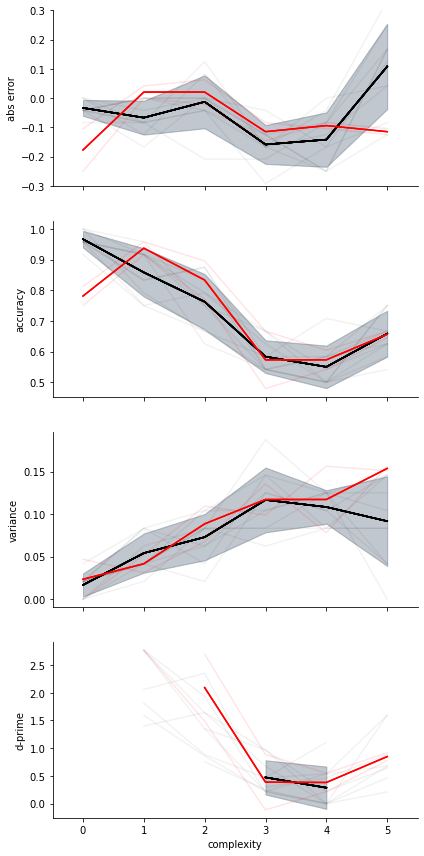

In [92]:
make_plots(X,Y)

In [49]:
y = compute_Y(local_dfs, 2, 6)

  0%|          | 0/10 [00:00<?, ?it/s]

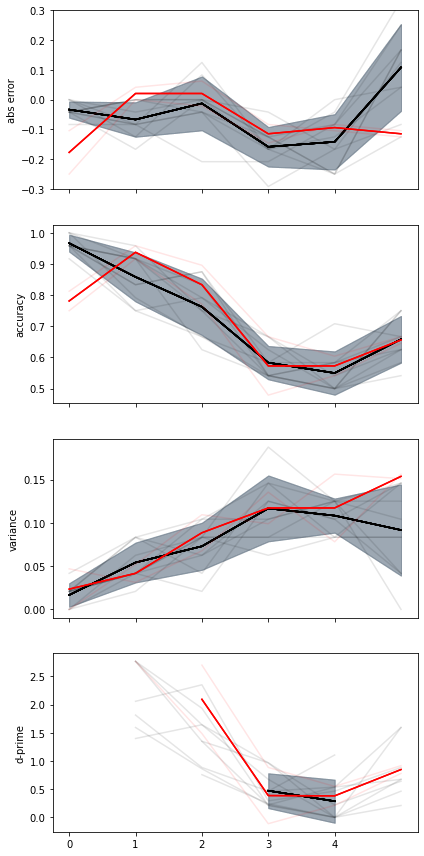

In [76]:
C,tau = 10, 7
nc,npc = 6, 2
n_sims,n_samples = 10, 2
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(local_dfs, npc, nc)
make_plots(X,Y)

  0%|          | 0/10 [00:00<?, ?it/s]

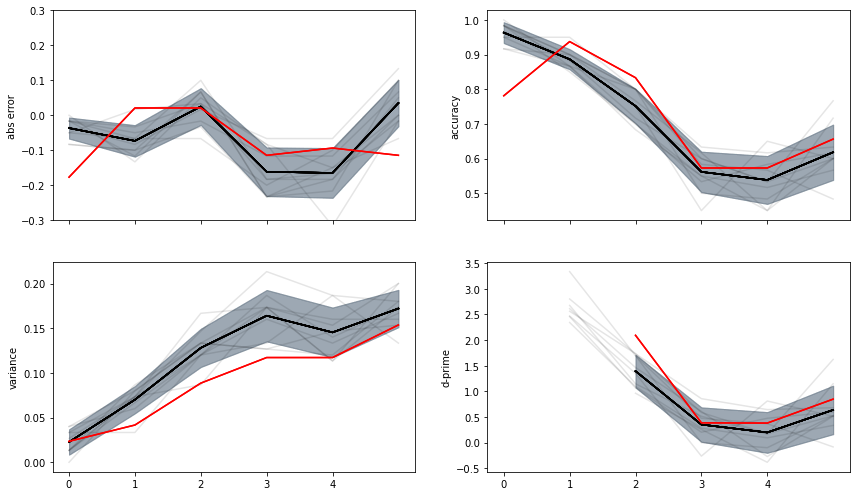

In [64]:
C,tau = 10, 7
nc,npc = 6, 2
n_sims,n_samples = 10, 5
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(local_dfs, npc, nc)
make_plots(X,Y)

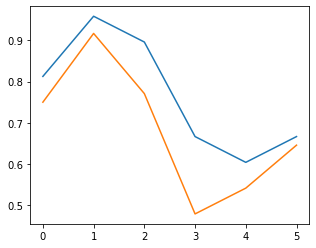

In [57]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(np.arange(6) , y[0][1])
ax.plot(np.arange(6) , y[1][1])

In [9]:
C,tau = .1, 5
nc,npc = 5, 4
n_sims,n_samples = 5, 2
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(local_dfs)
make_plots(X,Y)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyError: 'comparator'

  0%|          | 0/5 [00:00<?, ?it/s]

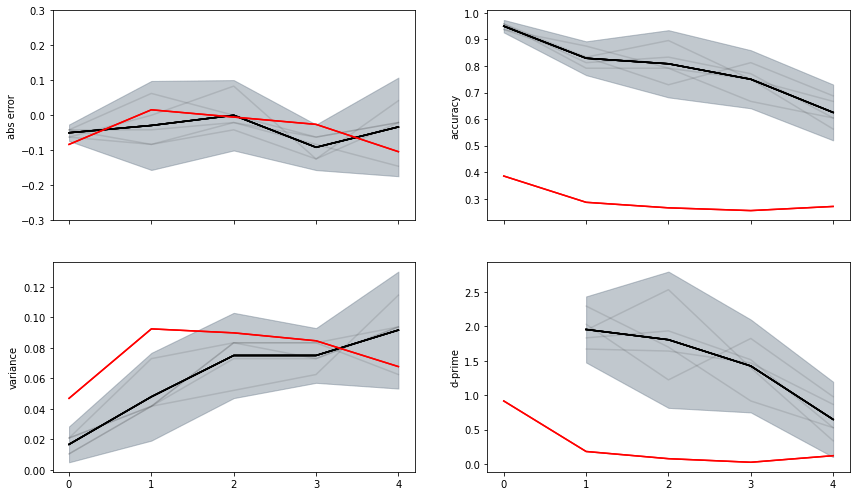

In [48]:
C,tau = 3, 5
nc,npc = 5, 4
n_sims,n_samples = 5, 2
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(online_dfs)
make_plots(X,Y)

  0%|          | 0/5 [00:00<?, ?it/s]

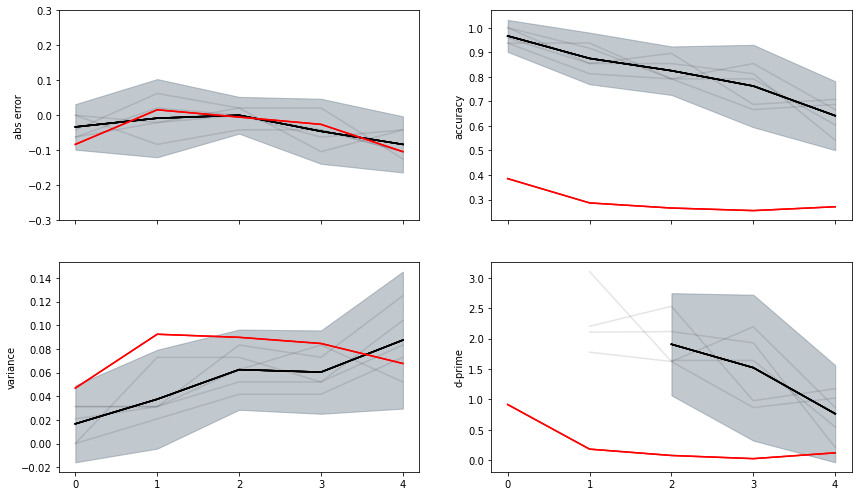

In [49]:
C,tau = 5, 5
nc,npc = 5, 4
n_sims,n_samples = 5, 2
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(online_dfs)
make_plots(X,Y)

  0%|          | 0/5 [00:00<?, ?it/s]

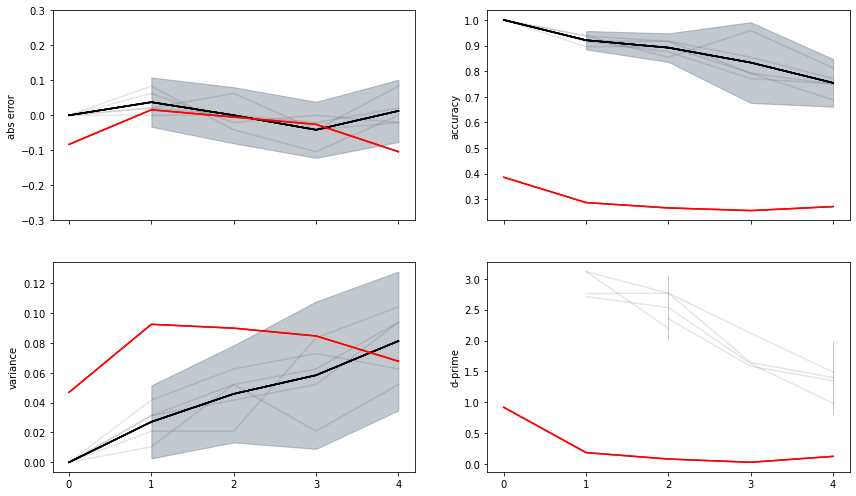

In [50]:
C,tau = 10, 5
nc,npc = 5, 4
n_sims,n_samples = 5, 2
X = run_n_simulations(targets, knots, probes, n_sims, n_samples, nc, npc, C, tau)
Y = compute_Y(online_dfs)
make_plots(X,Y)

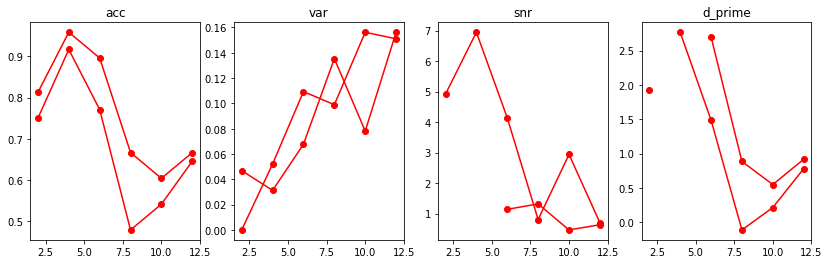

In [40]:
npc = 2  
avg_acc_subjects = []
avg_var_subjects = []
avg_snr_subjects = []
d_prime_subjects = []
for data in local_dfs:
    n_targets = len(list(set(data.target_id.values)))
    n_probes = len(list(set(data.probe_id.values)))
    n_repeats = len(data[(data.target_id==0) & (data.probe_id==0)])

    # compute the accuracy and error tensors
    R_img = np.ones((n_targets, n_probes, n_repeats)) * -1
    R_vis = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_comp = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_vis = np.ones((n_targets, n_probes, n_repeats)) * -1

    for tid in range(n_targets):
        for pid in range(n_probes):
            d = data[(data.target_id == tid) & (data.probe_id == pid)]
            resps = d['key_resp.keys'].values
            cor = d['correct_resp'].values
            comp = d['comparison'].values
            visn = d['n_isecs'].values
            for i, (r, c) in enumerate(zip(resps, cor)):
                R_img[tid, pid, i] = 1 if r == 'right' else 0
                R_vis[tid, pid, i] = 1 if c == 'right' else 0
                X_comp[tid, pid, i] = comp[i]
                X_vis[tid, pid, i] = visn[i]

    A = (R_img == R_vis).astype(int)
    E = R_img - R_vis

    avg_error = [e.mean() for e in split_by_complexity(E, npc)]
    avg_acc = [a.mean() for a in split_by_complexity(A, npc)]
    avg_var = [x.var(axis=2).mean() for x in split_by_complexity(R_img, npc)]
    avg_snr = [compute_SNR(x) for x in split_by_complexity(R_img, npc)]

    R = list(zip(split_by_complexity(R_vis, npc), split_by_complexity(R_img, npc)))
    d_prime = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R]
    
    avg_acc_subjects.append(avg_acc)
    avg_var_subjects.append(avg_var)
    avg_snr_subjects.append(avg_snr)
    d_prime_subjects.append(d_prime)
    


x = (np.arange(0, 6) * 2) + 2
labels = ['acc', 'var', 'snr', 'd_prime']
for a, y_subjects, title in zip(ax, [avg_acc_subjects, avg_var_subjects, avg_snr_subjects, d_prime_subjects], labels):
    for i,y in enumerate(y_subjects):
        ##print(len(x))
        #print(len(y))
        a.plot(x, y, c='red')
        a.scatter(x, y, c='red')
        a.set_title(title)
        
        
        
npc = 4
Y = np.zeros((len(online_dfs), 4, 5))

for sid,data in enumerate(online_dfs):
    n_targets = len(list(set(data.target_id.values)))
    n_probes = len(list(set(data.probe_id.values)))
    n_repeats = len(data[(data.target_id==0) & (data.probe_id==0)])

    # compute the accuracy and error tensors
    R_img = np.ones((n_targets, n_probes, n_repeats)) * -1
    R_vis = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_comp = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_vis = np.ones((n_targets, n_probes, n_repeats)) * -1

    for tid in range(n_targets):
        for pid in range(n_probes):
            d = data[(data.target_id == tid) & (data.probe_id == pid)]
            resps = d['key_resp.keys'].values
            cor = d['correct_resp'].values
            comp = d['comparator'].values
            visn = d['n_isecs'].values
            for i, (r, c) in enumerate(zip(resps, cor)):
                R_img[tid, pid, i] = 1 if r == 'right' else 0
                R_vis[tid, pid, i] = 1 if c == 'right' else 0
                X_comp[tid, pid, i] = comp[i]
                X_vis[tid, pid, i] = visn[i]

    A = (R_img == R_vis).astype(int)
    E = R_img - R_vis

    avg_error = [e.mean() for e in split_by_complexity(E, npc)]
    avg_acc = [a.mean() for a in split_by_complexity(A, npc)]
    avg_var = [x.var(axis=2).mean() for x in split_by_complexity(R_img, npc)]
    avg_snr = [compute_SNR(x) for x in split_by_complexity(R_img, npc)]
    R = list(zip(split_by_complexity(R_vis, npc), split_by_complexity(R_img, npc)))
    d_prime = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R]
    
    for j in range(len(avg_error)):
        Y[sid, 0, j] = avg_error[j]
        Y[sid, 1, j] = avg_acc[j]
        Y[sid, 2, j] = avg_var[j]
        Y[sid, 3, j] = d_prime[j]
  

In [41]:
Y.shape

(3, 4, 5)

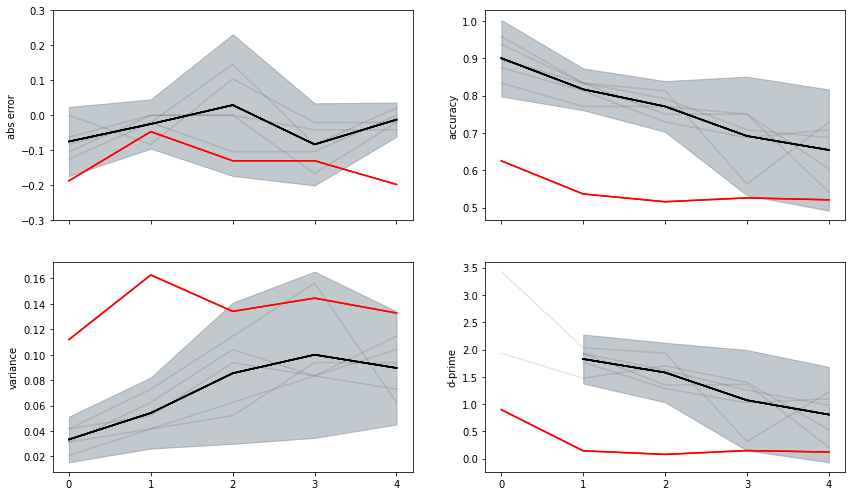

In [42]:
import scipy.stats as st

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 7), sharex=True)
x_range = np.arange(nc)
colors = ['slategrey', 'red']
for x, color in zip([X, Y[:2,:,:]], colors):
    for i in range(len(x)):
        labels = ['abs error','accuracy', 'variance', 'd-prime']
        for j,label in zip(range(4), labels):
            r, c = j//2, j%2
            if color == 'slategrey':
                ax[r][c].plot(x_range, x[i][j], c='black', alpha=.1)
            if color=='slategrey':
                ax[r][c].plot(x_range, x.mean(axis=0)[j], c='black')
            else:
                ax[r][c].plot(x_range, x.mean(axis=0)[j], c=color)


            ax[r][c].set_ylabel(label)


        for j, label in enumerate(labels):   
            r, c = j//2, j%2
            xlower, xupper = [],[]
            ylower, yupper = [],[]

            for i in range(len(x_range)):
                xlow, xhigh = st.t.interval(alpha=.99, df=n_sims-1, loc=x[:,j,i].mean(), scale=st.sem(x[:,j,i]))
                xlower.append(xlow)
                xupper.append(xhigh)
            if color == 'slategrey':
                ax[r][c].fill_between(x_range, xlower, y2=xupper, color=color, alpha=.1)


        for i in range(len(ax)):
            for j in range(len(ax[i])):
                ax[i][j].set_xticks(np.arange(5))
                #ax[i][j].set_xlabel('complexity')


ax[0][0].set_ylim(-.3, .3)
fig.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

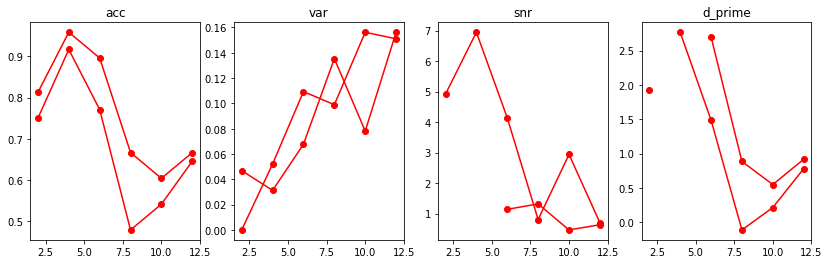

In [38]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)

npc = 2  
avg_acc_subjects = []
avg_var_subjects = []
avg_snr_subjects = []
d_prime_subjects = []
for data in local_dfs:
    n_targets = len(list(set(data.target_id.values)))
    n_probes = len(list(set(data.probe_id.values)))
    n_repeats = len(data[(data.target_id==0) & (data.probe_id==0)])

    # compute the accuracy and error tensors
    R_img = np.ones((n_targets, n_probes, n_repeats)) * -1
    R_vis = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_comp = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_vis = np.ones((n_targets, n_probes, n_repeats)) * -1

    for tid in range(n_targets):
        for pid in range(n_probes):
            d = data[(data.target_id == tid) & (data.probe_id == pid)]
            resps = d['key_resp.keys'].values
            cor = d['correct_resp'].values
            comp = d['comparison'].values
            visn = d['n_isecs'].values
            for i, (r, c) in enumerate(zip(resps, cor)):
                R_img[tid, pid, i] = 1 if r == 'right' else 0
                R_vis[tid, pid, i] = 1 if c == 'right' else 0
                X_comp[tid, pid, i] = comp[i]
                X_vis[tid, pid, i] = visn[i]

    A = (R_img == R_vis).astype(int)
    E = R_img - R_vis

    avg_error = [e.mean() for e in split_by_complexity(E, npc)]
    avg_acc = [a.mean() for a in split_by_complexity(A, npc)]
    avg_var = [x.var(axis=2).mean() for x in split_by_complexity(R_img, npc)]
    avg_snr = [compute_SNR(x) for x in split_by_complexity(R_img, npc)]

    R = list(zip(split_by_complexity(R_vis, npc), split_by_complexity(R_img, npc)))
    d_prime = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R]
    
    avg_acc_subjects.append(avg_acc)
    avg_var_subjects.append(avg_var)
    avg_snr_subjects.append(avg_snr)
    d_prime_subjects.append(d_prime)
    


x = (np.arange(0, 6) * 2) + 2
labels = ['acc', 'var', 'snr', 'd_prime']
for a, y_subjects, title in zip(ax, [avg_acc_subjects, avg_var_subjects, avg_snr_subjects, d_prime_subjects], labels):
    for i,y in enumerate(y_subjects):
        ##print(len(x))
        #print(len(y))
        a.plot(x, y, c='red')
        a.scatter(x, y, c='red')
        a.set_title(title)
        
        
        
npc = 4
Y = np.zeros((len(online_dfs), 4, 5))

for sid,data in enumerate(online_dfs):
    n_targets = len(list(set(data.target_id.values)))
    n_probes = len(list(set(data.probe_id.values)))
    n_repeats = len(data[(data.target_id==0) & (data.probe_id==0)])

    # compute the accuracy and error tensors
    R_img = np.ones((n_targets, n_probes, n_repeats)) * -1
    R_vis = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_comp = np.ones((n_targets, n_probes, n_repeats)) * -1
    X_vis = np.ones((n_targets, n_probes, n_repeats)) * -1

    for tid in range(n_targets):
        for pid in range(n_probes):
            d = data[(data.target_id == tid) & (data.probe_id == pid)]
            resps = d['key_resp.keys'].values
            cor = d['correct_resp'].values
            comp = d['comparator'].values
            visn = d['n_isecs'].values
            for i, (r, c) in enumerate(zip(resps, cor)):
                R_img[tid, pid, i] = 1 if r == 'right' else 0
                R_vis[tid, pid, i] = 1 if c == 'right' else 0
                X_comp[tid, pid, i] = comp[i]
                X_vis[tid, pid, i] = visn[i]

    A = (R_img == R_vis).astype(int)
    E = R_img - R_vis

    avg_error = [e.mean() for e in split_by_complexity(E, npc)]
    avg_acc = [a.mean() for a in split_by_complexity(A, npc)]
    avg_var = [x.var(axis=2).mean() for x in split_by_complexity(R_img, npc)]
    avg_snr = [compute_SNR(x) for x in split_by_complexity(R_img, npc)]
    R = list(zip(split_by_complexity(R_vis, npc), split_by_complexity(R_img, npc)))
    d_prime = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R]
    
    for j in range(len(avg_error)):
        Y[sid, 0, j] = avg_error[j]
        Y[sid, 1, j] = avg_acc[j]
        Y[sid, 2, j] = avg_var[j]
        Y[sid, 3, j] = d_prime[j]



#x = (np.arange(0, 5) * 2) + 2
#labels = ['acc', 'var', 'snr', 'd_prime']
#for a, y_subjects, title in zip(ax, [avg_acc_subjects, avg_var_subjects, avg_snr_subjects, d_prime_subjects], labels):
#    for i,y in enumerate(y_subjects):
#        a.plot(x, y, c='blue')
#        a.scatter(x, y,c='blue')
#        a.set_title(title)


#plt.show()    

In [26]:
Y.shape

(3, 4, 5)

In [82]:
Y[:2, :, :].shape

(2, 4, 5)

In [10]:
def run_simulation(targets, knots, probes, n_repeats, n_isecs, comparison, tau=7, capacity=2):
    n_targets, n_probes = len(targets), len(probes)
    X = np.ones((n_targets, n_probes, n_repeats)) *-1
    C = np.ones((n_targets, n_probes, n_repeats)) *-1
    R = np.ones((n_targets, n_probes, n_repeats)) *-1
    X_hat = np.ones((n_targets, n_probes, n_repeats)) *-1
    R_hat = np.ones((n_targets, n_probes, n_repeats)) *-1

    for i,(t,k) in tqdm(enumerate(zip(targets, knots))):
        model = IsotropicGaussian(k, capacity, tau)
        sample = model.sample_curves(n_probes*n_repeats)
        for j,p in enumerate(probes):
            n = n_isecs[i, j]
            c = comparison[i, j]
            #_,n = check_intersections(t, p)
            # c = n+.5 if ((i+j)%2 == 0) else n-.5
            r = 1 if n > c else 0
            for k in range(n_repeats):
                X[i, j, k] = n
                C[i, j, k] = c
                R[i, j, k] = r
                _,n_hat = check_intersections(sample[(j*n_repeats) + k], p)
                X_hat[i, j, k] = n_hat
                R_hat[i, j, k] = 1 if n_hat > c else 0
    
    return X, X_hat, R, R_hat


In [16]:
X_vis[:,:,0].shape

(20, 6)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

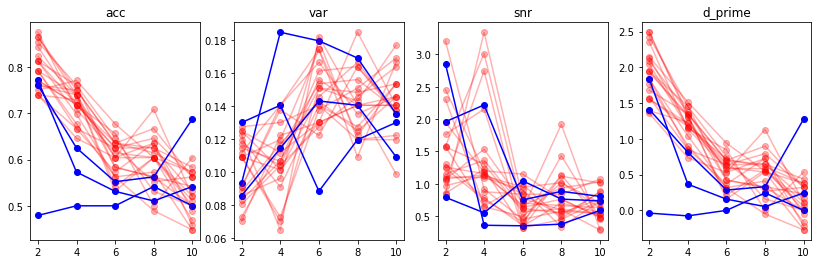

In [22]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)

c = 3
tau = 7
n_samples = 4
alpha = .3
n_sims = 20

npc = 4
comparison = X_comp[:,:,0]
n_isecs = X_vis[:,:,0]
    
x = (np.arange(0, 5) * 2) + 2
for _ in range(n_sims):
    color='red'
    _,_,R_vis_sim, R_img_sim = run_simulation(targets, knots, probes, n_samples, n_isecs, comparison, capacity=c)
    A_sim = (R_img_sim == R_vis_sim).astype(int)
    E_sim = R_img_sim - R_vis_sim
    avg_error_sim = [e.mean() for e in split_by_complexity(E_sim, npc)]
    avg_acc_sim = [a.mean() for a in split_by_complexity(A_sim, npc)]
    avg_var_sim = [x.var(axis=2).mean() for x in split_by_complexity(R_img_sim, npc)]
    avg_snr_sim = [compute_SNR(x) for x in split_by_complexity(R_img_sim, npc)]

    R_sim = list(zip(split_by_complexity(R_vis_sim, npc), split_by_complexity(R_img_sim, npc)))
    d_prime_sim = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R_sim]
    ax[0].plot(x, avg_acc_sim, c=color, alpha=alpha)
    ax[0].scatter(x, avg_acc_sim, c=color, alpha=alpha)
    ax[1].plot(x, avg_var_sim, c=color, alpha=alpha)
    ax[1].scatter(x, avg_var_sim, c=color, alpha=alpha)
    ax[2].plot(x, avg_snr_sim, c=color, alpha=alpha)
    ax[2].scatter(x, avg_snr_sim, c=color, alpha=alpha)
    ax[3].plot(x, d_prime_sim, c=color, alpha=alpha)
    ax[3].scatter(x, d_prime_sim, c=color, alpha=alpha)


for i in range(3):
    ax[0].plot(x, avg_acc_subjects[i], c='b')
    ax[0].scatter(x, avg_acc_subjects[i], c='b')
    ax[0].set_title('acc')
    ax[1].plot(x, avg_var_subjects[i], c='b')
    ax[1].scatter(x, avg_var_subjects[i], c='b')        
    ax[1].set_title('var')
    ax[2].plot(x, avg_snr_subjects[i], c='b')
    ax[2].scatter(x, avg_snr_subjects[i], c='b')        
    ax[2].set_title('snr')
    ax[3].plot(x, d_prime_subjects[i], c='b')
    ax[3].scatter(x, d_prime_subjects[i], c='b')
    ax[3].set_title('d_prime')


plt.show()

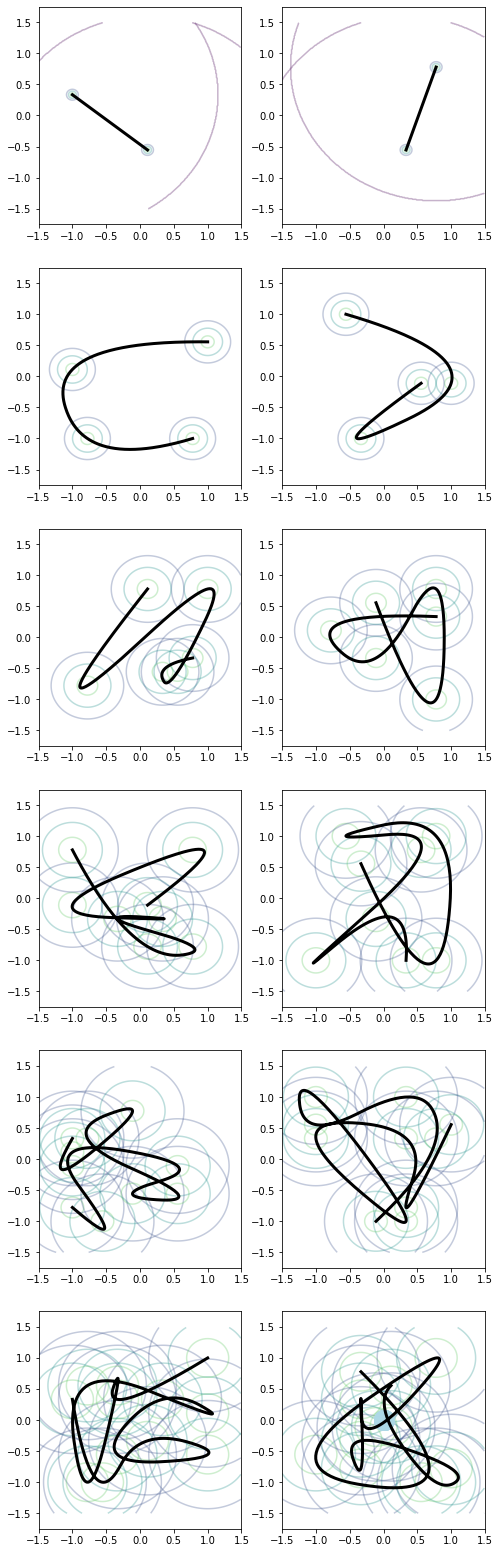

In [27]:
fig, ax = plt.subplots(figsize=(8, 28), ncols=2, nrows=6)
for i,k in enumerate(knots):
    model = IsotropicGaussian(k, c, tau)
    model.visualize(ax[i//2][i%2])

In [18]:
list(set(data[data.target_complexity==2].target_id.values))

[0.0, 1.0]